初期状態を選択(1:ガウス波束, 2:平面波) 1


NameError: name 'HTML' is not defined

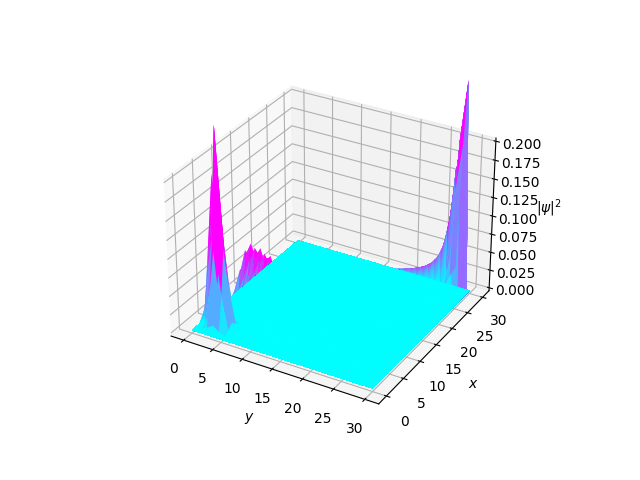

In [6]:
"""
量子ダイナミクスシミュレーション (2次元)
"""
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.animation as animation
import matplotlib.style as mplstyle


def set_initial_conditions(N, X, Y):
    """
    初期状態のセット

    Args:
        N(int): 行列サイズ
        X,Y : 位置座標
        
    Reterns:
        ndarray: 初期状態(N x N)
    """
    
    sigma = 0.05 * N
    x0 = N // 9  #波束の初期中心
    y0 = N // 9 
    psi0 = 0
    kx = 2
    ky = 2
    ic = int(input('初期状態を選択(1:ガウス波束, 2:平面波)'))

    if ic == 1:     #ガウス波束
        psi0 = np.exp(-((X - x0) ** 2 + (Y - y0) ** 2) / sigma ** 2) *np.exp(-1j * kx * (X - x0))*np.exp(-1j * ky * (Y - y0))
    if ic == 2:     #平面波
        psi0 = np.zeros((N, N))
        for i in range(N):
            psi0[i, 0] = 1

    return psi0
        

def set_initial_wave_function(psi0, Nt, N):
    """
    波動関数の初期化

    Args:
        ham (csr_matrix): ハミルトニアン (疎行列 N * N)
        psi0 (ndarray): 初期波動関数
        N (int): 行列サイズ
        Nt (int): 時間分割数
        Delta (float): Δ

    Returns:
        ndarray: 波動関数 (時刻0,1のみセット), psi[時刻, サイト] (Nt x N x N)
    """
    psi = np.zeros(((Nt, N, N)), dtype="complex")

    psi0 = psi0 / np.linalg.norm(psi0)
    psi[0] = psi0
    psi[1] = psi0
    
    return psi


def time_evolution(psi0, psi1, Delta, dx, dy, N):
    """
    時間発展

    Args:
        ham (csr_matrix): ハミルトニアン行列 (疎行列 N * N)
        psi0 (ndarray): 波動関数 (時刻 t-1)
        psi1 (ndarray): 波動関数 (時刻 t)
        Delta (float): Δ

    Returns:
        ndarray: 波動関数 (時刻 t+1)
    """
    B = 0.5
    psi2 = np.zeros((N,N), dtype="complex")
    for x in range(1,N-1):
        for y in range(1,N-1):
            #psi2[x,y] = psi0[x,y] + (1j*Delta)*(- (psi1[x+1,y]-2*psi1[x,y]+psi1[x-1,y]/dx**2) \
                                                       #- (psi1[x,y+1]-2*psi1[x,y]+psi1[x,y-1]/dy**2) \
                                                       #+ 2*B*1j*x*(psi1[x,y+1]-psi1[x,y-1]/2*dy) + (B**2)*(x**2)*psi1[x,y])
            psi2[x,y] = psi0[x,y] - (1j*Delta)*(- (psi1[x+1,y]-2*psi1[x,y]+psi1[x-1,y]/dx**2) \
                                                - (psi1[x,y+1]-2*psi1[x,y]+psi1[x,y-1]/dy**2) \
                                                + 1j*B*x*(psi1[x,y+1]-psi1[x,y-1]/2*dy) \
                                                - 1j*B*y*(psi1[x+1,y]-psi1[x-1,y]/2*dy) \
                                                + (B**2)*(x**2+y**2)*(psi1[x,y]) 
                                               )
    psi2 = psi2 / np.linalg.norm(psi2)

    return psi2


def plot_animation(figure, ax, N, xv, yv, Nt, psi):
    
    X, Y = np.meshgrid(xv, yv)
    ims = []
    for i in range(Nt):
        im = ax.plot_surface(X, Y, np.abs(psi[i]) ** 2, cmap = 'cool')        
        ims.append([im])
                  
                   
    ax.set_xlabel('$y$', fontsize = 10)
    ax.set_ylabel('$x$', fontsize = 10)
    ax.set_zlim3d(0, 0.2)
    ax.zaxis.set_rotate_label(False)      #z軸ラベルを縦にする
    ax.set_zlabel('$|ψ|^2$', fontsize = 10)
    ani = animation.ArtistAnimation(figure, ims, repeat = False)

    return ani

%matplotlib widget
def main():
    """
    メイン関数
    """
    Nx = 31  # 1次元サイト数
    Ny = 31
    Nt = 200  # 時刻の最大値
    Delta = 0.1  # Δ
    dx = 1
    dy = 1

    xv = np.array(range(Nx))  # 位置座標のセット
    yv = np.array(range(Ny))
    Y, X = np.meshgrid(yv, xv)
    tv = np.array(range(Nt)) * Delta  # 時刻のセット
    
    psi0 = set_initial_conditions(Nx, X, Y)  # 初期状態のセット
    psi = set_initial_wave_function(psi0, Nt, Nx)  # 初期波動関数の準備

    for t in range(Nt - 2):  #  時間発展
        psi[t + 2] = time_evolution(psi[t], psi[t + 1], Delta, dx, dy, Nx)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    ani = plot_animation(fig, ax, Nx, xv, yv, Nt, psi)  # 確率密度の時間発展アニメーション
    HTML(ani.to_html5_video())

    plt.show()
# ==================================================

main()